In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from focal_loss import SparseCategoricalFocalLoss
import tensorflow as tf
from tensorflow.keras import layers
from keras_tuner import HyperModel

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
import keras_tuner as kt
import keras
import os

tf.random.set_seed(42)
np.random.seed(42)

# Reading in pickle files

In [4]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

# Drop frame.time

In [5]:
X_train.drop(columns=['frame.time'], inplace=True)
X_test.drop(columns=['frame.time'], inplace=True)

# Separate Normal Traffic and Attack Traffic from data for Training AutoEncoder and FCN

In [ ]:
# Filter only Normal traffic from X_train 
normal_indices = y_train[y_train['Attack_type'] == 12].index
X_train_normal = X_train.iloc[normal_indices]

# Create y_test_label which is binary, 0 for normal 1 for attack
y_test_label = np.where(y_test['Attack_type'] == 12, 0, 1)
y_train_label = np.where(y_train['Attack_type'] == 12, 0, 1)

# Filter only Attack Traffic from X_train
attack_indices_train = y_train[y_train['Attack_type'] != 12].index
X_train_attack = X_train.iloc[attack_indices_train]
y_train_attack = y_train.iloc[attack_indices_train]

# Create y_test_label which only has attack
attack_indices_test = y_test[y_test['Attack_type'] != 12].index
X_test_attack = X_test.iloc[attack_indices_test]
y_test_attack = y_test.iloc[attack_indices_test]

# SMOTE

In [42]:
# SMOTE on Attack Traffic
smote = SMOTE(random_state=42)
X_resampled_attack, y_resampled_attack = smote.fit_resample(X_train_attack, y_train_attack)

# Fine Tuning

In [66]:

class AttackFCNHypModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        
        # Hyperparameter for the number of units in the first layer
        model.add(layers.Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=64),
        input_dim=X_resampled_attack.shape[1],
        activation='leaky_relu'))
        model.add(layers.Dropout(0.2))

        # Hyperparameter for the number of units in the second layer
        model.add(layers.Dense(
        units=hp.Int('units_2', min_value=64, max_value=256, step=32),
        activation='leaky_relu'))
        model.add(layers.Dropout(0.2))

        # Hyperparameter for the number of units in the third layer
        model.add(layers.Dense(
        units=hp.Int('units_3', min_value=32, max_value=128, step=32),
        activation='leaky_relu'))
        model.add(layers.Dropout(0.2))

        # Hyperparameter for the number of units in the first layer
        model.add(layers.Dense(
        units=hp.Int('units_4', min_value=128, max_value=512, step=64),
        activation='leaky_relu'))
        model.add(layers.LayerNormalization())
        model.add(layers.Dropout(0.2))

        # Output layer
        model.add(layers.Dense(units=12, activation='softmax'))

        # Compile the model with a tunable learning rate
        model.compile(optimizer=keras.optimizers.AdamW(
            learning_rate=0.01),
            loss=SparseCategoricalFocalLoss(hp.Float('focal_loss_gamma', min_value=1.0, max_value=3.0, step=0.5)),
            metrics=['accuracy'])
        
        return model
    
attack_fcn_hypermodel = AttackFCNHypModel()

tuner = kt.Hyperband(
    attack_fcn_hypermodel,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='attack_fcn_hyperband')

# Add early stopping to the tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Add ReduceLROnPlateau to the tuner
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

tuner.search(X_resampled_attack, y_resampled_attack, epochs=100, validation_split=0.2, callbacks=[stop_early, reduce_lr])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 232 Complete [12h 22m 50s]
val_loss: 1.1656858921051025

Best val_loss So Far: 0.6945260167121887
Total elapsed time: 1d 14h 53m 52s

Search: Running Trial #233

Value             |Best Value So Far |Hyperparameter
192               |512               |units_1
128               |128               |units_2
128               |64                |units_3
256               |512               |units_4
3                 |3                 |focal_loss_gamma
34                |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
1                 |4                 |tuner/bracket
0                 |4                 |tuner/round



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/34
31261/31261 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.8162 - loss: 0.2177 - val_accuracy: 0.2232 - val_loss: 1.2166 - learning_rate: 0.0100
Epoch 2/34
31261/31261 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.8501 - loss: 0.1669 - val_accuracy: 0.2471 - val_loss: 1.1076 - learning_rate: 0.0100
Epoch 3/34
31261/31261 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.8512 - loss: 0.1650 - val_accuracy: 0.2533 - val_loss: 1.1292 - learning_rate: 0.0100
Epoch 4/34
31261/31261 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.8511 - loss: 0.1651 - val_accuracy: 0.2444 - val_loss: 1.1943 - learning_rate: 0.0100
Epoch 5/34
31261/31261 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.8518 - loss: 0.1644 - val_accuracy: 0.2405 - val_loss: 1.1471 - learning_rate: 0.0100
Epoch 6/34
31261/31261 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.8613 - loss: 0.1513 - val_accuracy: 0.2745 - val_loss: 1.0475 - learning_rate: 0.0050
Epoch 7/34
22700/31261 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - 

KeyboardInterrupt: 

# Final 2 Part Model

## AutoEncoder

In [7]:
# Model
input_dim = X_train_normal.shape[1]

ae_no_time = Sequential()
ae_no_time.add(Dense(units=input_dim, input_dim=input_dim, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=128, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=64, activation='leaky_relu'))
ae_no_time.add(Dense(units=32, activation='leaky_relu'))
ae_no_time.add(Dense(units=64, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=128, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=input_dim, activation='leaky_relu'))
 
ae_no_time.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=7,          # Number of epochs to wait after no improvement
                               restore_best_weights=True)  # Restores model to the best weights when stopped

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    # Metric to monitor
                              factor=0.5,           # Factor by which to reduce the learning rate
                              patience=5,           # Number of epochs with no improvement before reducing LR
                              min_lr=1e-6)  

# Train using normal traffic data for both inputs and outputs
ae_no_time_hist = ae_no_time.fit(X_train_normal, X_train_normal,  
                epochs=100,                   
                batch_size=500,
                validation_split=0.2,
                callbacks = [early_stopping,reduce_lr])       



c:\Users\Gram\Downloads\dsa4266_proj\dsa4266\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5601 - loss: 0.0238 - val_accuracy: 0.7163 - val_loss: 6.2180e-04 - learning_rate: 0.0010
Epoch 2/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6930 - loss: 0.0029 - val_accuracy: 0.6875 - val_loss: 3.4573e-04 - learning_rate: 0.0010
Epoch 3/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7069 - loss: 0.0020 - val_accuracy: 0.6903 - val_loss: 2.5061e-04 - learning_rate: 0.0010
Epoch 4/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7108 - loss: 0.0016 - val_accuracy: 0.7161 - val_loss: 1.9862e-04 - learning_rate: 0.0010
Epoch 5/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7121 - loss: 0.0014 - val_accuracy: 0.6766 - val_loss: 2.0834e-04 - learning_rate: 0.0010
Epoch 6/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7124 - loss: 0.0013 - val_accuracy: 0.6726 - val_loss: 1.9448e-04 - learning_rate: 0.0010
Epoch 7/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 

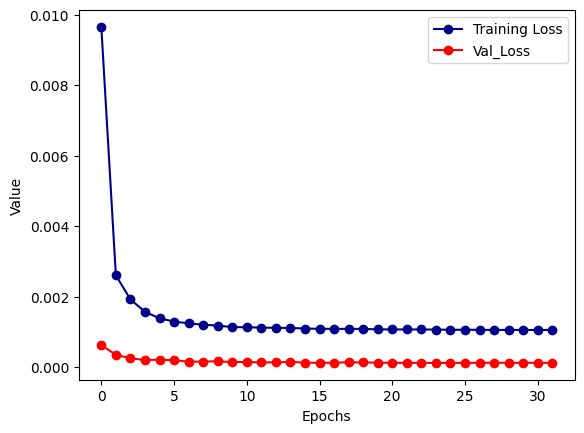

In [8]:
# Training and Validation Loss Plots
plt.plot(ae_no_time_hist.history['loss'], label='Training Loss', marker='o', color='darkblue')
plt.plot(ae_no_time_hist.history['val_loss'], label='Val_Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

46320/46320 ━━━━━━━━━━━━━━━━━━━━ 66s 1ms/step
19852/19852 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    367217
           1       1.00      1.00      1.00    268028

    accuracy                           1.00    635245
   macro avg       1.00      1.00      1.00    635245
weighted avg       1.00      1.00      1.00    635245



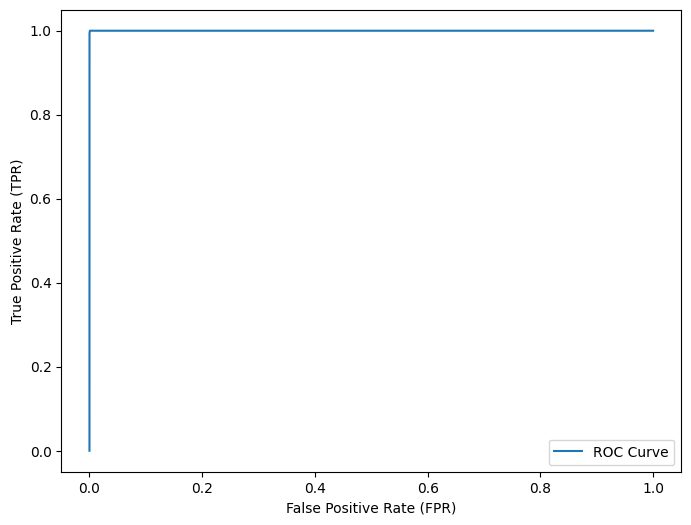

In [9]:
###################################################################################################
# Predictions
ae_no_time_pred = ae_no_time.predict(X_train)
# MSE between true X_train and pred_X_train
mse_no_time = np.mean(np.power(X_train - ae_no_time_pred, 2), axis=1)

###################################################################################################
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_train_label, mse_no_time)
youden_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_index]

###################################################################################################
# Identify Anomaly based on MSE Threshold
ae_no_time_pred = ae_no_time.predict(X_test)
# MSE between true X_test and pred_X_test
mse_no_time = np.mean(np.power(X_test - ae_no_time_pred, 2), axis=1)

anomaly_labels_no_time = np.where(mse_no_time > optimal_threshold, 1, 0)

###################################################################################################
#  Classification Report 
print(classification_report(y_test_label, anomaly_labels_no_time))

###################################################################################################
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()

## Fully Connected Network  

In [88]:
# Model
attack_FCN_no_time = Sequential()
attack_FCN_no_time.add(Dense(units=448, input_dim=X_train_attack.shape[1],activation='leaky_relu'))
attack_FCN_no_time.add(LayerNormalization())
attack_FCN_no_time.add(Dropout(0.2))

attack_FCN_no_time.add(Dense(units=128,activation='leaky_relu'))
attack_FCN_no_time.add(LayerNormalization())

attack_FCN_no_time.add(Dense(units=128,activation='leaky_relu'))
attack_FCN_no_time.add(LayerNormalization())
attack_FCN_no_time.add(Dropout(0.2))

attack_FCN_no_time.add(Dense(units=192,activation='leaky_relu'))
attack_FCN_no_time.add(LayerNormalization())

attack_FCN_no_time.add(Dense(units=12, activation='softmax'))

attack_FCN_no_time.compile(optimizer='adamw', loss= SparseCategoricalFocalLoss(gamma = 3), metrics=['accuracy'])

checkpoint_path = "best_model.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss',   
    save_best_only=True, 
    save_weights_only=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    # Metric to monitor
                              factor=0.5,           # Factor by which to reduce the learning rate
                              patience=10,           # Number of epochs with no improvement before reducing LR
                              min_lr=1e-6)  

attack_FCN_no_time_hist = attack_FCN_no_time.fit(X_train_attack, y_train_attack, batch_size=500, epochs=250,callbacks=[checkpoint_callback,reduce_lr],validation_split=0.2)


Epoch 1/250


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 997/1001 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7784 - loss: 0.3076
Epoch 1: val_loss improved from inf to 0.19119, saving model to best_model.weights.h5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7785 - loss: 0.3072 - val_accuracy: 0.8360 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 2/250
1000/1001 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8320 - loss: 0.1930
Epoch 2: val_loss improved from 0.19119 to 0.18777, saving model to best_model.weights.h5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8320 - loss: 0.1930 - val_accuracy: 0.8371 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 3/250
 994/1001 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8359 - loss: 0.1873
Epoch 3: val_loss improved from 0.18777 to 0.18726, saving model to best_model.weights.h5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8359 - loss: 0.1873 - val_accuracy: 0.8388 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 4/250
 995/1001 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

In [89]:
attack_FCN_no_time.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 448)            │        44,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_26          │ (None, 448)            │           896 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_27          │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_28          │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_29          │ (None, 192)            │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 12)             │         2,316 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,638 (1.68 MB)

 Trainable params: 147,212 (575.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294,426 (1.12 MB)

8376/8376 ━━━━━━━━━━━━━━━━━━━━ 4s 427us/step
                       precision    recall  f1-score   support

             Backdoor       0.99      0.94      0.97      7459
            DDoS_HTTP       0.80      0.90      0.85     44658
            DDoS_ICMP       1.00      1.00      1.00     43715
             DDoS_TCP       1.00      1.00      1.00     42422
    OS_Fingerprinting       1.00      0.84      0.92       300
             Password       0.78      0.88      0.83     44242
        Port_Scanning       0.87      1.00      0.93      6769
           Ransomware       0.93      0.87      0.90      3278
        SQL_injection       0.88      0.62      0.73     15361
            Uploading       0.90      0.75      0.82     11290
Vulnerability_scanner       0.99      0.93      0.96     43759
                  XSS       0.88      0.39      0.54      4775

             accuracy                           0.91    268028
            macro avg       0.92      0.84      0.87    268028
        

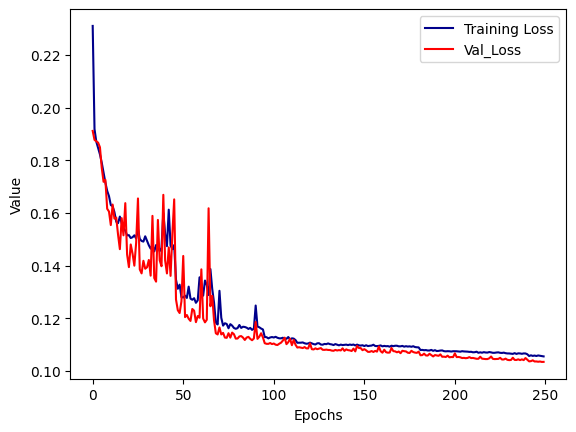

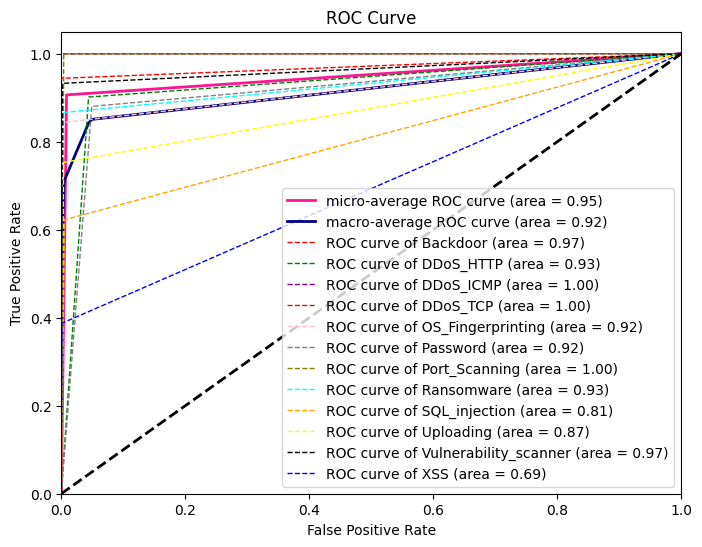

In [90]:
###################################################################################################
# Load best weights
attack_FCN_no_time.load_weights(checkpoint_path)

###################################################################################################
# Prediction
y_pred_prob_no_time = attack_FCN_no_time.predict(X_test_attack)
y_pred_no_time = np.argmax(y_pred_prob_no_time, axis=1)

###################################################################################################
# Classification Report
target_names = ['Backdoor',
                'DDoS_HTTP',
                'DDoS_ICMP',
                'DDoS_TCP',
                'OS_Fingerprinting',
                'Password',
                'Port_Scanning',
                'Ransomware',
                'SQL_injection',
                'Uploading',
                'Vulnerability_scanner',
                'XSS']
print(classification_report(y_test_attack, y_pred_no_time,target_names= target_names))

###################################################################################################
# Training and Validation Loss Plots
plt.plot(attack_FCN_no_time_hist.history['loss'], label='Training Loss', color='darkblue')
plt.plot(attack_FCN_no_time_hist.history['val_loss'], label='Val_Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


###################################################################################################
# ROC Curves for all Attack_type
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    ## plot micro and macro auc-roc curve
    type_mapping = {
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11} 
    reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    for i, color in zip(range(n_classes), colors):
        # class_name = lb.classes_[i]
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
             linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test_attack, y_pred_no_time, n_classes=len(np.unique(y_test_attack)))

# Combining Both AE and FCN

19852/19852 ━━━━━━━━━━━━━━━━━━━━ 5s 269us/step
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 3s 406us/step
                       precision    recall  f1-score   support

             Backdoor       0.99      0.94      0.97      7459
            DDoS_HTTP       0.80      0.90      0.85     44658
            DDoS_ICMP       1.00      1.00      1.00     43715
             DDoS_TCP       1.00      1.00      1.00     42422
    OS_Fingerprinting       1.00      0.84      0.92       300
             Password       0.78      0.88      0.83     44242
        Port_Scanning       0.85      1.00      0.92      6769
           Ransomware       0.93      0.87      0.90      3278
        SQL_injection       0.88      0.62      0.73     15361
            Uploading       0.90      0.75      0.82     11290
Vulnerability_scanner       0.99      0.93      0.96     43759
                  XSS       0.88      0.39      0.54      4775
               Normal       1.00      1.00      1.00    367217

             accuracy   

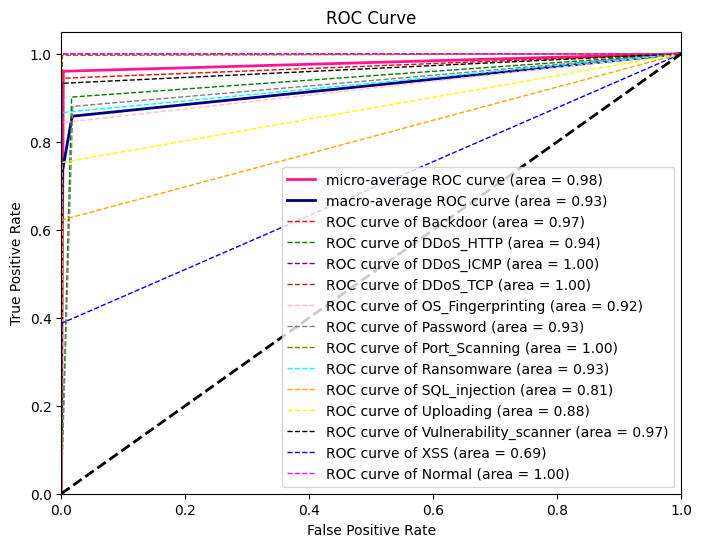

In [ ]:
def combined_predict_no_time(X_test):
    # Step 1: Autoencoder Prediction for Anomaly Detection
    reconstruction = ae_no_time.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - reconstruction), axis=1)
    
    # Determine anomalies based on threshold chosen when evaluating AE
    threshold = optimal_threshold

    # based on threshold determine which are normal
    is_anomaly = reconstruction_error > threshold

    y_pred = np.full(len(X_test), 12)  # Initialize predictions as "Normal" (or 12)

    # Classify anomalies with the FCN model
    if np.any(is_anomaly):
        anomaly_data = X_test[is_anomaly]
        y_pred_anomaly = attack_FCN_no_time.predict(anomaly_data).argmax(axis=1)  # Get predicted attack class
        y_pred[is_anomaly] = y_pred_anomaly
    return y_pred

###################################################################################################
# Classification Report
final_y_pred_no_time = combined_predict_no_time(X_test)
target_names = ['Backdoor',
                'DDoS_HTTP',
                'DDoS_ICMP',
                'DDoS_TCP',
                'OS_Fingerprinting',
                'Password',
                'Port_Scanning',
                'Ransomware',
                'SQL_injection',
                'Uploading',
                'Vulnerability_scanner',
                'XSS',
                'Normal']
print(classification_report(y_test, final_y_pred_no_time,target_names=target_names)) 


###################################################################################################
# ROC Curves for all Attack_type
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    ## plot micro and macro auc-roc curve
    type_mapping = {
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11,
    'Normal':12} 
    reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    for i, color in zip(range(n_classes), colors):
        # class_name = lb.classes_[i]
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
             linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test, final_y_pred_no_time, n_classes=len(np.unique(y_test)))

# Extract Embeddings

In [102]:
# Extract the embedding layer output
embedding_layer = attack_FCN_no_time.get_layer(index=-1) 
embeddings = embedding_layer.weights[0]  # The weights of the embedding layer

print(embedding_layer)
print(embeddings.shape)

<Dense name=dense_44, built=True>
(192, 12)


In [103]:
input_layer = attack_FCN_no_time.get_layer(index=0)
input_weights = input_layer.get_weights()[0]
print(input_layer)
print(input_weights.shape)
print(input_layer.input)

<Dense name=dense_40, built=True>
(98, 448)
<KerasTensor shape=(None, 98), dtype=float32, sparse=None, name=keras_tensor_613>


In [104]:
embedding_model = Model(inputs=input_layer.input, outputs=embedding_layer.output)

In [105]:
n_samples = 10000
embeddings = embedding_model.predict(X_train_attack[:n_samples])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


In [106]:
LOGS_DIR = os.path.join(os.getcwd(), 'logs')

type_mapping = {
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11,
    'Normal':12} 
reverse_type_mapping = {v: k for k, v in type_mapping.items()}

labels = y_train_attack[:n_samples]["Attack_type"].to_list()
labels = [reverse_type_mapping[label] for label in labels]

if not os.path.exists(LOGS_DIR):
    os.makedirs(LOGS_DIR)

with open(os.path.join(LOGS_DIR, "metadata.tsv"), "w") as f:
    for label in labels:
        f.write(f"{label}\n")

np.savetxt(os.path.join(LOGS_DIR, "embeddings.tsv"), embeddings, delimiter="\t")